In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV


#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Current working directory: /shared_folder/eas_508_project


In [54]:
pbp_path = 'data/interim/pbp/'

pbp_name = 'featured_11_13.csv'

df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})
shape = df.shape
columns = df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

df.head()

/tmp/ipykernel_39307/2280615120.py:5: DtypeWarning: Columns (84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})


✔✔✔ File Loaded

Shape: (307576, 114)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'n_offense', 'n_defense', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'yrdln', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'run_location', 'run_gap', 'score_differential', 'no_score_prob', 'fg_prob', 'td_prob', 'ep', 'epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'penalty', 'field_goal_attempt', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 'season', 'order_sequence', 'stadium', 'weather', 'nfl_api_id', 'fixed_drive'

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,n_offense,n_defense,home_team,...,fp_success,smoothed_fp_success,fp_epa,f_success,smoothed_f_success,f_epa,yard_group,previous_success,home,spread
0,2016_01_BUF_BAL,58,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,0to5,0.0,1,-3.0
1,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173,0to5,1.0,1,-3.0
2,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.464400,0.462669,0.057628,0.441437,0.441424,0.021173,0to5,1.0,1,-3.0
3,2016_01_BUF_BAL,130,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,5to10,0.0,1,-3.0
4,2016_01_BUF_BAL,154,BAL,UNDER_CENTER,"1 RB, 2 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.420136,0.420369,0.006901,0.429168,0.429205,0.010042,0to5,1.0,1,-3.0


In [ ]:
# Useable Features
features = ['down',
            'ydstogo',
            'ydstosuccess',
            'yard_group',
            'yardline_100',
            'previous_success',
            'success',
            'offense_formation',
            'defenders_in_box',
            'QB',
            'RB',
            'TE',
            'WR',
            'OL',
            'O_OTHER',
            'DL',
            'LB',
            'DB',
            'D_OTHER',
            'home',
            'score_differential',
            'spread',
            'total_line',
            'qtr',
            'quarter_seconds_remaining']
cat_features = ['yard_group',
                'offense_formation']
target = 'success'

In [ ]:
model_df = df[features]
for col in cat_features:
    model_df[col] = model_df[col].astype(str)
    model_df[col] = LabelEncoder().fit_transform(model_df[col])
model_df = model_df.copy()

X = model_df.drop(columns=target)
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42, stratify=model_df[target])

In [114]:
scale = 1/y_train.mean()

model = xgb.XGBClassifier(
    n_estimators = 500,
    learning_rate = .05,
    scale_pos_weight = scale,
    max_depth=12,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [115]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

print(classification_report(y_test, y_pred))

Accuracy: 0.5159145588139671
AUC: 0.5861769188597843
              precision    recall  f1-score   support

         0.0       0.66      0.29      0.41     34651
         1.0       0.47      0.80      0.59     26865

    accuracy                           0.52     61516
   macro avg       0.56      0.55      0.50     61516
weighted avg       0.58      0.52      0.49     61516



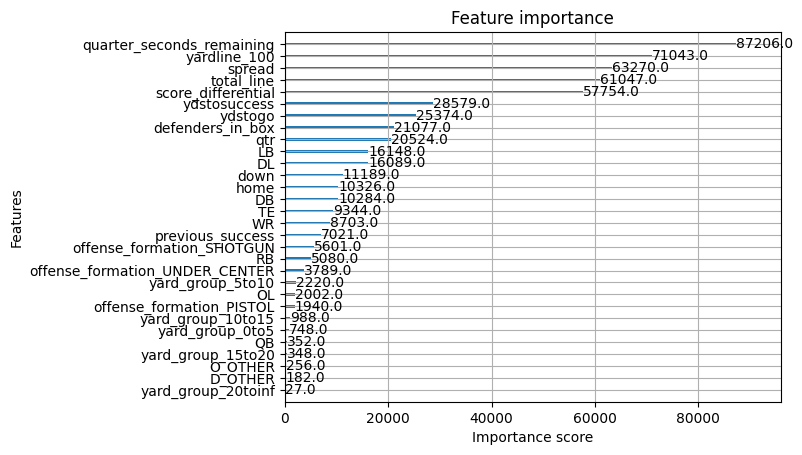

In [116]:
xgb.plot_importance(model)
plt.show()

In [117]:
for i in np.linspace(.4, .6, 20):
    y_prob_pred = (y_proba > i).astype(int)
    print(classification_report(y_test, y_prob_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.15      0.25     34651
         1.0       0.45      0.91      0.61     26865

    accuracy                           0.48     61516
   macro avg       0.57      0.53      0.43     61516
weighted avg       0.59      0.48      0.40     61516

              precision    recall  f1-score   support

         0.0       0.68      0.16      0.26     34651
         1.0       0.46      0.90      0.61     26865

    accuracy                           0.49     61516
   macro avg       0.57      0.53      0.43     61516
weighted avg       0.58      0.49      0.41     61516



              precision    recall  f1-score   support

         0.0       0.68      0.17      0.28     34651
         1.0       0.46      0.90      0.60     26865

    accuracy                           0.49     61516
   macro avg       0.57      0.53      0.44     61516
weighted avg       0.58      0.49      0.42     61516

              precision    recall  f1-score   support

         0.0       0.68      0.19      0.29     34651
         1.0       0.46      0.89      0.60     26865

    accuracy                           0.49     61516
   macro avg       0.57      0.54      0.45     61516
weighted avg       0.58      0.49      0.43     61516

              precision    recall  f1-score   support

         0.0       0.68      0.20      0.31     34651
         1.0       0.46      0.88      0.60     26865

    accuracy                           0.50     61516
   macro avg       0.57      0.54      0.46     61516
weighted avg       0.58      0.50      0.44     61516

              preci

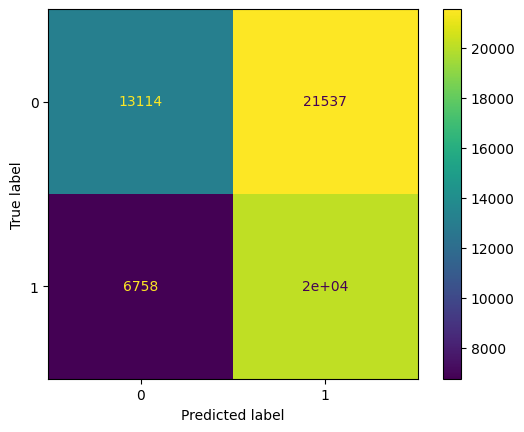

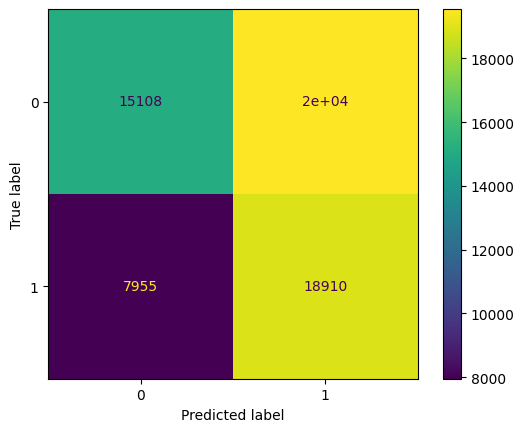

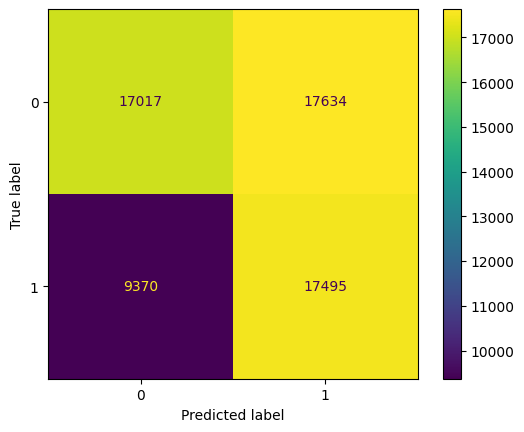

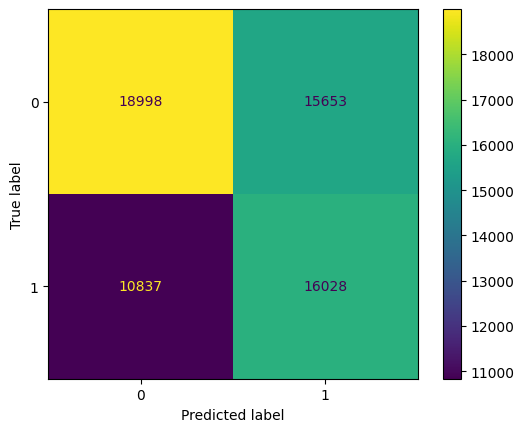

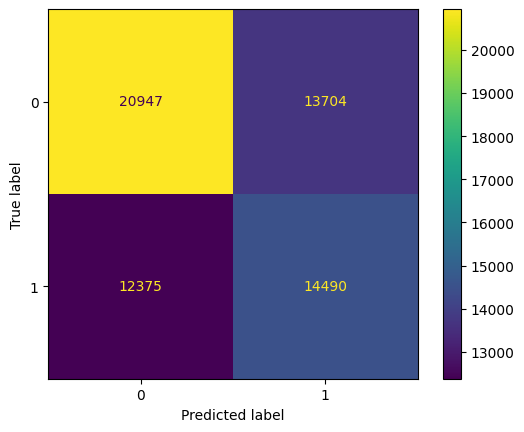

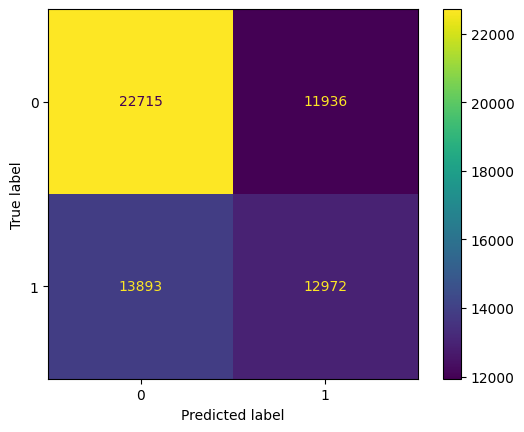

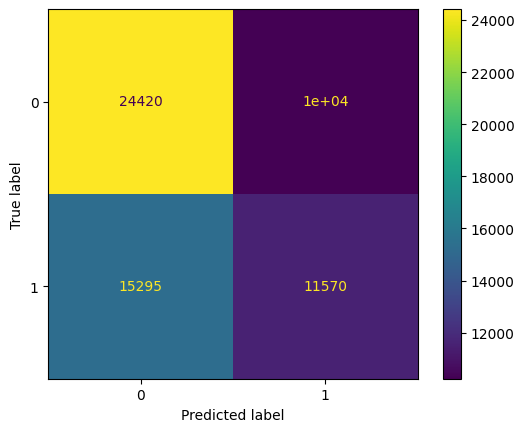

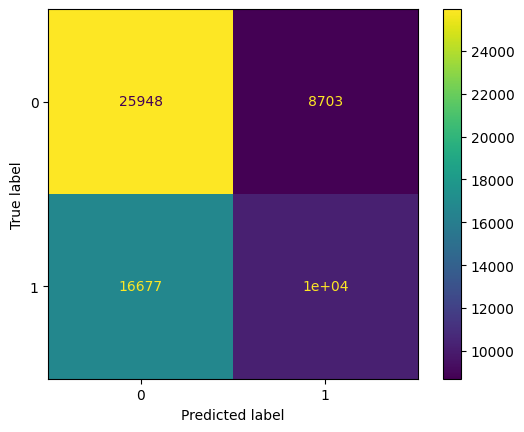

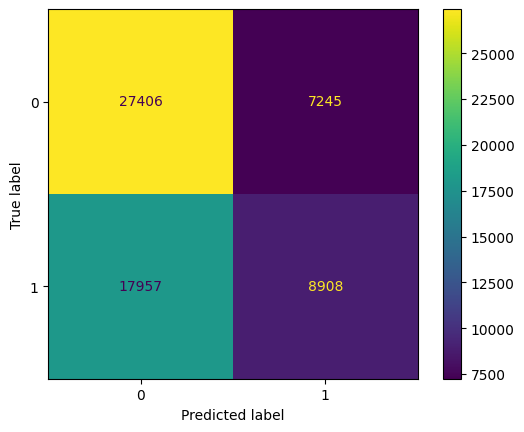

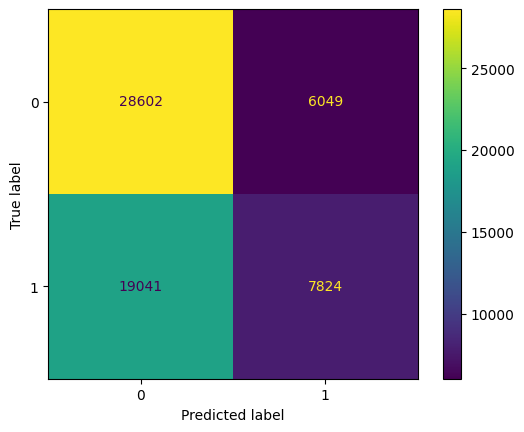

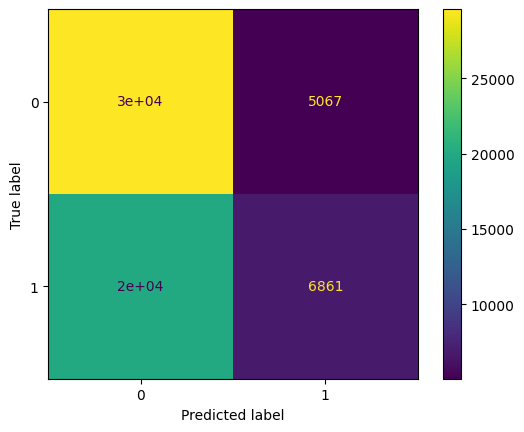

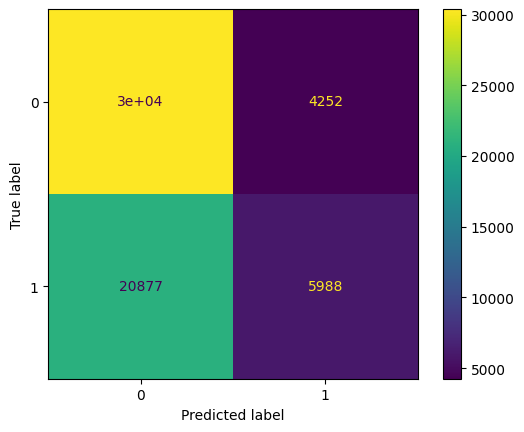

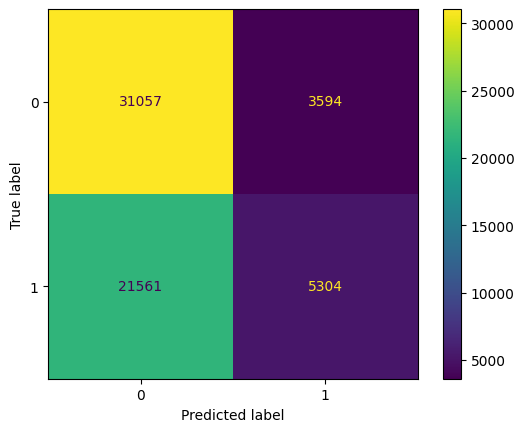

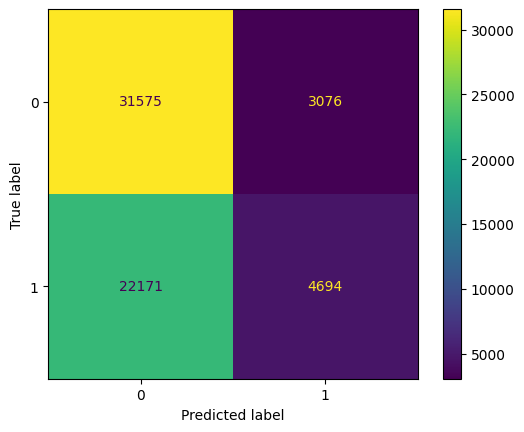

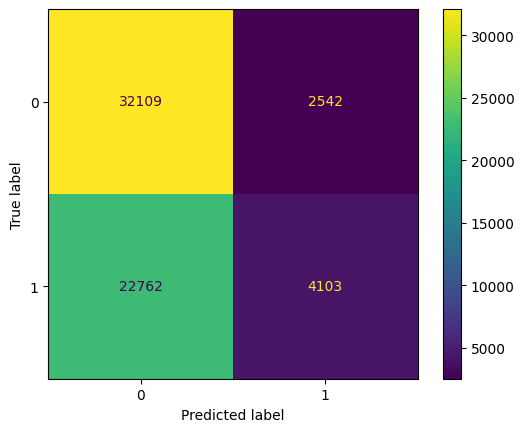

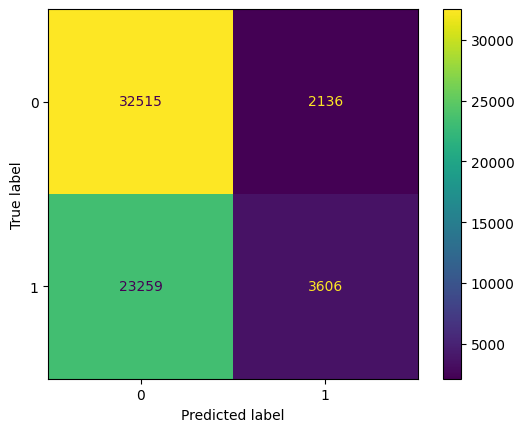

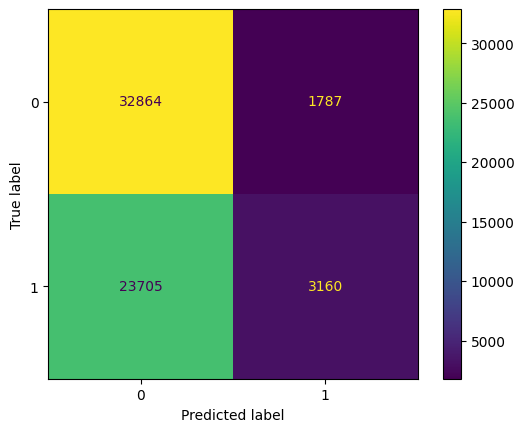

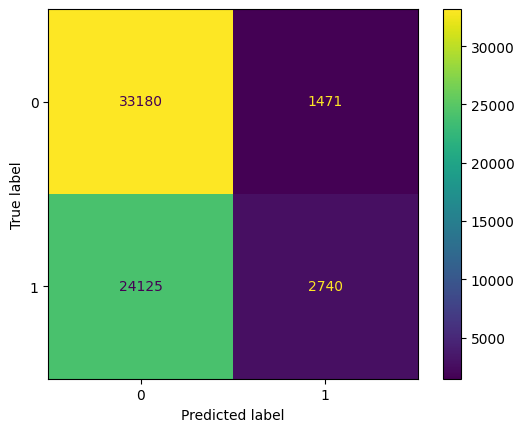

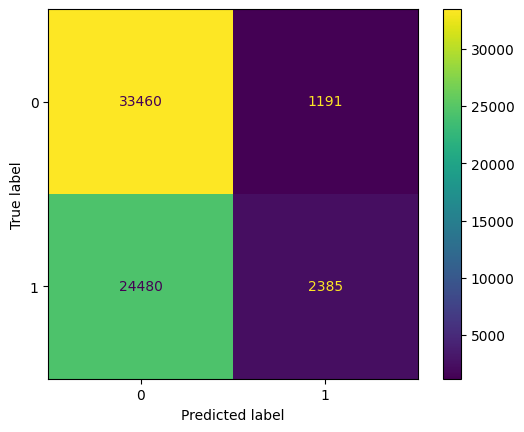

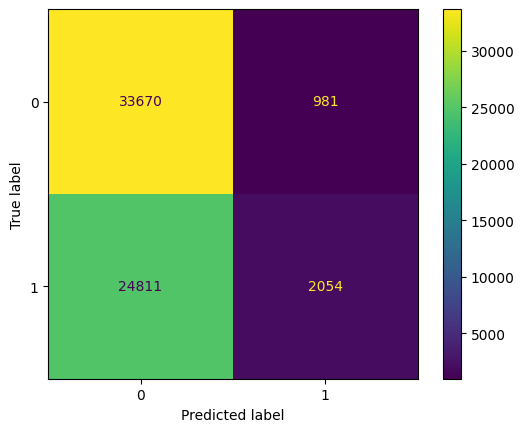

In [93]:
for i in np.linspace(.4, .6, 20):
    y_prob_pred = (y_proba > i).astype(int)
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_prob_pred)).plot()

In [105]:
params = {'subsample': np.float64(0.6842105263157895), 'reg_lambda': np.float64(1.438449888287663), 'reg_alpha': np.float64(0.0069519279617756054), 'n_estimators': np.int64(700), 'min_child_weight': np.int64(4), 'max_depth': np.int64(8), 'learning_rate': np.float64(0.019999999999999997), 'gamma': np.float64(3.4210526315789473), 'colsample_bytree': np.float64(0.8947368421052632)}
